<a href="https://colab.research.google.com/github/chinthanishanth/deep_learning/blob/master/Python%20MP%20Neuron%20Perceptron/Mobile_Like_and_Dislike_Prediction_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import files

# # Install Kaggle library
# !pip install -q kaggle

In [0]:
# uploaded = files.upload()

In [0]:
# !cp kaggle.json /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

In [0]:
# !kaggle competitions download -c padhai-module1-assignment2

In [0]:
# !unzip train.csv.zip

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, log_loss
import operator
import json
from IPython import display
import os
import warnings

np.random.seed(0)
warnings.filterwarnings("ignore")
THRESHOLD = 4

Task: To predict whether the user likes the mobile phone or not. <br>
Assumption: If the average rating of mobile >= threshold, then the user likes it, otherwise not.


<b>Missing values:</b><br>
'Also Known As'(459),'Applications'(421),'Audio Features'(437),'Bezel-less display'(266),'Browser'(449),'Build Material'(338),'Co-Processor'(451),'Display Colour'(457),'Mobile High-Definition Link(MHL)'(472),'Music'(447)
'Email','Fingerprint Sensor Position'(174),'Games'(446),'HDMI'(454),'Heart Rate Monitor'(467),'IRIS Scanner'(467),
'Optical Image Stabilisation'(219),'Other Facilities'(444),'Phone Book'(444),'Physical Aperture'(87),'Quick Charging'(122),'Ring Tone'(444),'Ruggedness'(430),SAR Value(315),'SIM 3'(472),'SMS'(470)', 'Screen Protection'(229),'Screen to Body Ratio (claimed by the brand)'(428),'Sensor'(242),'Software Based Aperture'(473),
'Special Features'(459),'Standby time'(334),'Stylus'(473),'TalkTime'(259), 'USB Type-C'(374),'Video Player'(456),
'Video Recording Features'(458),'Waterproof'(398),'Wireless Charging','USB OTG Support'(159), 'Video ,'Recording'(113),'Java'(471),'Browser'(448)

<b>Very low variance:</b><br>
'Architecture'(most entries are 64-bit),'Audio Jack','GPS','Loudspeaker','Network','Network Support','Other Sensors'(28),'SIM Size', 'VoLTE'


<b>Multivalued:</b><br>
'Colours','Custom UI','Model'(1),'Other Sensors','Launch Date'

<b>Not important:</b><br>
'Bluetooth', 'Settings'(75),'Wi-Fi','Wi-Fi Features'

<b>Doubtful:</b><br>
'Aspect Ratio','Autofocus','Brand','Camera Features','Fingerprint Sensor'(very few entries are missing),
'Fingerprint Sensor Position', 'Graphics'(multivalued),'Image resolution'(multivalued),'SIM Size','Sim Slot(s)', 'User Available Storage', 'SIM 1', 'SIM 2','Shooting Modes', 'Touch Screen'(24), 'USB Connectivity'
    
<b>To check:</b><br>
'Display Type','Expandable Memory','FM Radio'

<b>High Correlation with other features</b><br>
'SIM Slot(s)' high correlation with SIM1
'Weight' has high high correlation with capacity , screen-to-body ratio
'Height' - screen size is also there
    
<b>Given a mobile, we can't directly get these features</b><br>
'Rating Count', 'Review Count'

<b>Keeping:</b><br>
'Capacity','Flash'(17),'Height'(22),'Internal Memory'(20, require cleaning),'Operating System'(25, require cleaning), 'Pixel Density'(1, clean it),'Processor'(22, clean it), 'RAM'(17, clean), 'Rating','Resolution'(cleaning), 'Screen Resolution','Screen Size', 'Thickness'(22), 'Type','User Replaceable','Weight'(cleaning),'Sim Size'(), 'Other Sensors'(28), 'Screen to Body Ratio (calculated)','Width',


In [7]:
# read data from file
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 355
Number of features in train: 99
Number of data points in test: 119
Number of features in test: 98


In [8]:
train.head()

,PhoneId,Also Known As,Applications,Architecture,Aspect Ratio,Audio Features,Audio Jack,Autofocus,Bezel-less display,Bluetooth,Brand,Browser,Build Material,Camera Features,Capacity,Chipset,Co-Processor,Colours,Custom UI,Display Colour,Display Type,Email,Expandable Memory,FM Radio,Fingerprint Sensor,Fingerprint Sensor Position,Flash,GPS,Games,Graphics,HDMI,Heart Rate Monitor,Height,IRIS Scanner,Image Resolution,Internal Memory,Java,Launch Date,Loudspeaker,Mobile High-Definition Link(MHL),...,Ruggedness,SAR Value,SIM 1,SIM 2,SIM 3,SIM Size,SIM Slot(s),SMS,Screen Protection,Screen Resolution,Screen Size,Screen to Body Ratio (calculated),Screen to Body Ratio (claimed by the brand),Sensor,Settings,Shooting Modes,Software Based Aperture,Special Features,Standby time,Stylus,TalkTime,Thickness,Touch Screen,Type,USB Connectivity,USB OTG Support,USB Type-C,User Available Storage,User Replaceable,Video Player,Video Recording,Video Recording Features,VoLTE,Waterproof,Weight,Wi-Fi,Wi-Fi Features,Width,Wireless Charging,Rating
0,0,NaN,NaN,64 bit,19:9,NaN,3.5 mm,Phase Detection autofocus,yes,v5.0,Xiaomi,NaN,NaN,"Digital Zoom, Auto Flash, Face detection, Touc...",4000 mAh,Qualcomm Snapdragon 636,NaN,"Black, Blue, Red, Rose Gold",MIUI,NaN,IPS LCD,NaN,Up to 256 GB,NaN,yes,Rear,Dual-color LED Flash,"with A-GPS, Glonass",NaN,Adreno 509,NaN,NaN,157.9 mm Compare Size,NaN,4000 x 3000 Pixels,64 GB Best in Class ▾Internal Memory compared ...,NaN,"November 23, 2018 (Official)",yes,NaN,...,NaN,NaN,4G Bands:TD-LTE 2300(band 40) / 2500(band 41) ...,4G Bands: TD-LTE 2300(band 40) / 2500(band 41)...,NaN,"SIM1: Nano, SIM2: Nano (Hybrid)","Dual SIM, GSM+GSM, Dual VoLTE",NaN,Corning Gorilla Glass,1080 x 2280 pixels,6.26 inches (15.9 cm),80.68 %,NaN,Exmor RS,"Exposure compensation, ISO control","Continuos Shooting, High Dynamic Range mode (H...",NaN,NaN,NaN,NaN,NaN,8.2 mm Very Good ▾Thickness compared to11 - 17...,"Capacitive Touchscreen, Multi-touch",Li-Polymer,"Mass storage device, USB charging, microUSB 2.0",yes,NaN,Up to 52.3 GB,No,NaN,1920x1080 @ 30 fps,NaN,yes,NaN,182 grams Below Average ▾Weight compared to11 ...,"Wi-Fi 802.11, a/b/g/n","Wi-Fi Direct, Mobile Hotspot",76.4 mm,NaN,4.5
1,1,NaN,Oppo Browser,64 bit,19:9,NaN,3.5 mm,Phase Detection autofocus,yes,v4.2,Realme,NaN,NaN,"2 x Digital Zoom, Auto Flash, Face detection, ...",4230 mAh,Qualcomm Snapdragon 450,NaN,"Diamond Black, Diamond Blue, Diamond Red",ColorOS,NaN,IPS LCD,NaN,Up to 256 GB,NaN,yes,Rear,LED Flash,with A-GPS,NaN,Adreno 506,NaN,NaN,156.2 mm Compare Size,NaN,4128 x 3096 Pixels,32 GB Excellent ▾Internal Memory compared to8 ...,NaN,"September 4, 2018 (Official)",yes,NaN,...,NaN,NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,NaN,"SIM1: Nano, SIM2: Nano","Dual SIM, GSM+GSM, Dual VoLTE",NaN,Corning Gorilla Glass v3,720 x 1520 pixels,6.2 inches (15.75 cm),80.85 %,88.8 %,NaN,"Exposure compensation, ISO control","Continuos Shooting, High Dynamic Range mode (HDR)",NaN,NaN,NaN,NaN,Up to 44 Hours(2G),8.2 mm Very Good ▾Thickness compared to8 - 12 ...,"Capacitive Touchscreen, Multi-touch",Li-ion,"Mass storage device, USB charging, microUSB 2.0",yes,NaN,Up to 23.2 GB,No,NaN,1920x1080 @ 30 fps,NaN,yes,NaN,168 grams Average ▾Weight compared to8 - 12 K ...,"Wi-Fi 802.11, b/g/n",Mobile Hotspot,75.6 mm,NaN,4.5
2,2,NaN,NaN,64 bit,19.5:9,NaN,3.5 mm,yes,yes,v4.2,Realme,NaN,NaN,"2 x Digital Zoom, Auto Flash, Face detection, ...",3500 mAh,MediaTek Helio P70,NaN,"Brave Blue, Fiery Gold, Ambitious Black",ColorOS,NaN,IPS LCD,NaN,Up to 256 GB,yes,yes,Rear,LED Flash,"with A-GPS, Glonass",NaN,Mali-G72 MP3,NaN,NaN,157 mm Compare Size,NaN,4128 x 3096 Pixels,32 GB Excellent ▾Internal Memory compared to10...,NaN,"December 5, 2018 (Official)",yes,NaN,...,NaN,NaN,4G Bands:TD-LTE 2600(band 38) / 2300(band 40) ...,4G Bands: TD-LTE 2600(band 38) / 2300(band 40)...,NaN,"SIM1: Nano, SIM2: Nano","Dual SIM, GSM+GSM, Dual VoLTE",NaN,Corning Gorilla Glass v3,1080 x 2340 pixels,6.

In [0]:
def data_clean(data):
    
    # Let's first remove all missing value features
    columns_to_remove = ['Also Known As','Applications','Audio Features','Bezel-less display'
                         'Browser','Build Material','Co-Processor','Browser'
                         'Display Colour','Mobile High-Definition Link(MHL)',
                         'Music', 'Email','Fingerprint Sensor Position',
                         'Games','HDMI','Heart Rate Monitor','IRIS Scanner', 
                         'Optical Image Stabilisation','Other Facilities',
                         'Phone Book','Physical Aperture','Quick Charging',
                         'Ring Tone','Ruggedness','SAR Value','SIM 3','SMS',
                         'Screen Protection','Screen to Body Ratio (claimed by the brand)',
                         'Sensor','Software Based Aperture', 'Special Features',
                         'Standby time','Stylus','TalkTime', 'USB Type-C',
                         'Video Player', 'Video Recording Features','Waterproof',
                         'Wireless Charging','USB OTG Support', 'Video Recording','Java']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    #Features having very low variance 
    columns_to_remove = ['Architecture','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Multivalued:
    columns_to_remove = ['Architecture','Launch Date','Audio Jack','GPS','Loudspeaker','Network','Network Support','VoLTE', 'Custom UI']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    # Not much important
    columns_to_remove = ['Bluetooth', 'Settings','Wi-Fi','Wi-Fi Features']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]
    
    return data

# Removing features

In [0]:
train = data_clean(train)
test = data_clean(test)

removing all those data points in which more than 15 features are missing 

1.   List item
2.   List item


In [0]:
train = train[(train.isnull().sum(axis=1) <= 15)]

In [12]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 47
Number of data points in test: 119
Number of features in test: 46


# Filling Missing values

In [0]:
def for_integer(test):
    try:
        test = test.strip()
        return int(test.split(' ')[0])
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass

def for_string(test):
    try:
        test = test.strip()
        return (test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

def for_float(test):
    try:
        test = test.strip()
        return float(test.split(' ')[0])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass

    
def for_Internal_Memory(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[1] == 'GB':
            return int(test[0])
        if test[1] == 'MB':
#             print("here")
            return (int(test[0]) * 0.001)
    except IOError:
           pass
    except ValueError:
        pass
    except:
        pass
    
def find_freq(test):
    try:
        test = test.strip()
        test = test.split(' ')
        if test[2][0] == '(':
            return float(test[2][1:])
        return float(test[2])
    except IOError:
        pass
    except ValueError:
        pass
    except:
        pass


In [0]:
def data_clean_2(x):
    data = x.copy()
    
    data['Capacity'] = data['Capacity'].apply(for_integer)

    data['Height'] = data['Height'].apply(for_float)
    data['Height'] = data['Height'].fillna(data['Height'].mean())

    data['Internal Memory'] = data['Internal Memory'].apply(for_Internal_Memory)

    data['Pixel Density'] = data['Pixel Density'].apply(for_integer)

    data['Internal Memory'] = data['Internal Memory'].fillna(data['Internal Memory'].median())
    data['Internal Memory'] = data['Internal Memory'].astype(int)

    data['RAM'] = data['RAM'].apply(for_integer)
    data['RAM'] = data['RAM'].fillna(data['RAM'].median())
    data['RAM'] = data['RAM'].astype(int)

    data['Resolution'] = data['Resolution'].apply(for_integer)
    data['Resolution'] = data['Resolution'].fillna(data['Resolution'].median())
    data['Resolution'] = data['Resolution'].astype(int)

    data['Screen Size'] = data['Screen Size'].apply(for_float)

    data['Thickness'] = data['Thickness'].apply(for_float)
    data['Thickness'] = data['Thickness'].fillna(data['Thickness'].mean())
    data['Thickness'] = data['Thickness'].round(2)

    data['Type'] = data['Type'].fillna('Li-Polymer')

    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].apply(for_float)
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].fillna(data['Screen to Body Ratio (calculated)'].mean())
    data['Screen to Body Ratio (calculated)'] = data['Screen to Body Ratio (calculated)'].round(2)

    data['Width'] = data['Width'].apply(for_float)
    data['Width'] = data['Width'].fillna(data['Width'].mean())
    data['Width'] = data['Width'].round(2)

    data['Flash'][data['Flash'].isna() == True] = "Other"

    data['User Replaceable'][data['User Replaceable'].isna() == True] = "Other"

    data['Num_cores'] = data['Processor'].apply(for_string)
    data['Num_cores'][data['Num_cores'].isna() == True] = "Other"


    data['Processor_frequency'] = data['Processor'].apply(find_freq)
    #because there is one entry with 208MHz values, to convert it to GHz
    data['Processor_frequency'][data['Processor_frequency'] > 200] = 0.208
    data['Processor_frequency'] = data['Processor_frequency'].fillna(data['Processor_frequency'].mean())
    data['Processor_frequency'] = data['Processor_frequency'].round(2)

    data['Camera Features'][data['Camera Features'].isna() == True] = "Other"

    #simplifyig Operating System to os_name for simplicity
    data['os_name'] = data['Operating System'].apply(for_string)
    data['os_name'][data['os_name'].isna() == True] = "Other"

    data['Sim1'] = data['SIM 1'].apply(for_string)

    data['SIM Size'][data['SIM Size'].isna() == True] = "Other"

    data['Image Resolution'][data['Image Resolution'].isna() == True] = "Other"

    data['Fingerprint Sensor'][data['Fingerprint Sensor'].isna() == True] = "Other"

    data['Expandable Memory'][data['Expandable Memory'].isna() == True] = "No"

    data['Weight'] = data['Weight'].apply(for_integer)
    data['Weight'] = data['Weight'].fillna(data['Weight'].mean())
    data['Weight'] = data['Weight'].astype(int)

    data['SIM 2'] = data['SIM 2'].apply(for_string)
    data['SIM 2'][data['SIM 2'].isna() == True] = "Other"
    
    return data

In [15]:
train = data_clean_2(train)
test = data_clean_2(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 51
Number of data points in test: 119
Number of features in test: 50


In [0]:
def data_clean_3(x):
    
    data = x.copy()

    columns_to_remove = ['User Available Storage','SIM Size','Chipset','Processor','Autofocus','Aspect Ratio','Touch Screen',
                        'Bezel-less display','Operating System','SIM 1','USB Connectivity','Other Sensors','Graphics','FM Radio',
                        'NFC','Shooting Modes','Browser','Display Colour' ]

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = [ 'Screen Resolution','User Replaceable','Camera Features',
                        'Thickness', 'Display Type']

    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]


    columns_to_remove = ['Fingerprint Sensor', 'Flash', 'Rating Count', 'Review Count','Image Resolution','Type','Expandable Memory',\
                        'Colours','Width','Model']
    columns_to_retain = list(set(data.columns)-set(columns_to_remove))
    data = data[columns_to_retain]

    return data

In [17]:
train = data_clean_3(train)
test = data_clean_3(test)

# check the number of features and data points in train
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 341
Number of features in train: 18
Number of data points in test: 119
Number of features in test: 17


In [18]:
# one hot encoding

train_ids = train['PhoneId']
test_ids = test['PhoneId']

cols = list(test.columns)
cols.remove('PhoneId')
cols.insert(0, 'PhoneId')

combined = pd.concat([train.drop('Rating', axis=1)[cols], test[cols]])
print(combined.shape)
print(combined.columns)

combined = pd.get_dummies(combined)
print(combined.shape)
print(combined.columns)

train_new = combined[combined['PhoneId'].isin(train_ids)]
test_new = combined[combined['PhoneId'].isin(test_ids)]

(460, 17)
Index(['PhoneId', 'Height', 'SIM 2', 'RAM', 'SIM Slot(s)', 'Pixel Density',
       'Resolution', 'Capacity', 'Screen Size',
       'Screen to Body Ratio (calculated)', 'os_name', 'Weight', 'Sim1',
       'Internal Memory', 'Num_cores', 'Brand', 'Processor_frequency'],
      dtype='object')
(460, 87)
Index(['PhoneId', 'Height', 'RAM', 'Pixel Density', 'Resolution', 'Capacity',
       'Screen Size', 'Screen to Body Ratio (calculated)', 'Weight',
       'Internal Memory', 'Processor_frequency', 'SIM 2_2G', 'SIM 2_3G',
       'SIM 2_4G', 'SIM 2_Other', 'SIM Slot(s)_Dual SIM, GSM+CDMA',
       'SIM Slot(s)_Dual SIM, GSM+GSM',
       'SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE',
       'SIM Slot(s)_Single SIM, GSM', 'os_name_Android', 'os_name_Blackberry',
       'os_name_KAI', 'os_name_Nokia', 'os_name_Other', 'os_name_Tizen',
       'os_name_iOS', 'Sim1_2G', 'Sim1_3G', 'Sim1_4G', 'Num_cores_312',
       'Num_cores_Deca', 'Num_cores_Dual', 'Num_cores_Hexa', 'Num_cores_Octa',
      

In [0]:
train_new = train_new.merge(train[['PhoneId', 'Rating']], on='PhoneId')

In [20]:
# check the number of features and data points in train
print("Number of data points in train: %d" % train_new.shape[0])
print("Number of features in train: %d" % train_new.shape[1])

# check the number of features and data points in test
print("Number of data points in test: %d" % test_new.shape[0])
print("Number of features in test: %d" % test_new.shape[1])

Number of data points in train: 341
Number of features in train: 88
Number of data points in test: 119
Number of features in test: 87


In [0]:
# save the cleaned csv 
train_new.to_csv("train_cleaned.csv", index=False)
test_new.to_csv("test_cleaned.csv", index=False)

In [22]:
train_data = pd.read_csv("train_cleaned.csv")
train_data['Rating'] =  train_data.Rating.apply(lambda x : 1 if x >= THRESHOLD else 0)
train_data.head()


,PhoneId,Height,RAM,Pixel Density,Resolution,Capacity,Screen Size,Screen to Body Ratio (calculated),Weight,Internal Memory,Processor_frequency,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,...,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Rating
0,0,157.9,4,403,20,4000,6.26,80.68,182,64,1.8,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,1,156.2,3,271,8,4230,6.20,80.85,168,32,1.8,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,157.0,3,409,25,3500,6.30,83.68,168,32,2.1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,4,159.8,4,411,24,3300,6.00,74.78,169,64,2.2,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,5,160.4,4,396,16,3750,6.50,84.23,175,64,2.2,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
train_data.describe()

,PhoneId,Height,RAM,Pixel Density,Resolution,Capacity,Screen Size,Screen to Body Ratio (calculated),Weight,Internal Memory,Processor_frequency,SIM 2_2G,SIM 2_3G,SIM 2_4G,SIM 2_Other,"SIM Slot(s)_Dual SIM, GSM+CDMA","SIM Slot(s)_Dual SIM, GSM+GSM","SIM Slot(s)_Dual SIM, GSM+GSM, Dual VoLTE","SIM Slot(s)_Single SIM, GSM",os_name_Android,os_name_Blackberry,os_name_KAI,os_name_Nokia,os_name_Other,os_name_Tizen,os_name_iOS,Sim1_2G,Sim1_3G,Sim1_4G,Num_cores_312,Num_cores_Deca,Num_cores_Dual,Num_cores_Hexa,Num_cores_Octa,Num_cores_Other,Num_cores_Quad,Num_cores_Tru-Octa,Brand_10.or,Brand_Apple,Brand_Asus,...,Brand_Honor,Brand_Huawei,Brand_InFocus,Brand_Infinix,Brand_Intex,Brand_Itel,Brand_Jivi,Brand_Karbonn,Brand_LG,Brand_Lava,Brand_LeEco,Brand_Lenovo,Brand_Lephone,Brand_Lyf,Brand_Meizu,Brand_Micromax,Brand_Mobiistar,Brand_Moto,Brand_Motorola,Brand_Nokia,Brand_Nubia,Brand_OPPO,Brand_OnePlus,Brand_Oppo,Brand_Panasonic,Brand_Razer,Brand_Realme,Brand_Reliance,Brand_Samsung,Brand_Sony,Brand_Spice,Brand_Tecno,Brand_Ulefone,Brand_VOTO,Brand_Vivo,Brand_Xiaomi,Brand_Xiaomi Poco,Brand_Yu,Brand_iVooMi,Rating
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,...,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000
mean,232.970674,149.946394,11.120235,344.211144,9.592375,3191.307918,5.462317,72.353343,161.343109,46.369501,1.792551,0.211144,0.020528,0.683284,0.085044,0.002933,0.759531,0.152493,0.085044,0.906158,0.005865,0.005865,0.002933,0.020528,0.002933,0.055718,0.020528,0.020528,0.958944,0.002933,0.005865,0.029326,0.035191,0.580645,0.017595,0.325513,0.002933,0.005865,0.055718,0.023460,...,0.049853,0.017595,0.008798,0.008798,0.011730,0.011730,0.002933,0.005865,0.026393,0.017595,0.002933,0.043988,0.002933,0.002933,0.005865,0.043988,0.011730,0.043988,0.005865,0.061584,0.002933,0.041056,0.008798,0.017595,0.011730,0.002933,0.011730,0.002933,0.129032,0.026393,0.0,0.023460,0.002933,0.002933,0.076246,0.061584,0.008798,0.011730,0.002933,0.697947
std,137.231746,9.192305,61.320855,88.161129,5.953827,932.533527,0.742529,9.357839,22.305556,46.435453,0.451598,0.408720,0.142006,0.465879,0.279357,0.054153,0.427996,0.360026,0.279357,0.292037,0.076471,0.076471,0.054153,0.142006,0.054153,0.229714,0.142006,0.142006,0.198711,0.054153,0.076471,0.168965,0.184532,0.494179,0.131668,0.469255,0.054153,0.076471,0.229714,0.151583,...,0.217962,0.131668,0.093520,0.093520,0.107827,0.107827,0.054153,0.076471,0.160536,0.131668,0.054153,0.205370,0.054153,0.054153,0.076471,0.205370,0.107827,0.205370,0.076471,0.240751,0.054153,0.198711,0.093520,0.131668,0.107827,0.054153,0.107827,0.054153,0.335728,0.160536,0.0,0.151583,0.054153,0.054153,0.265782,0.240751,0.093520,0.107827,0.054153,0.459823
min,0.000000,115.600000,1.000000,143.000000,2.000000,1020.000000,2.400000,23.600000,58.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

In [0]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

X_train =  train_data.drop('Rating', axis=1)
Y_train = train_data['Rating']


In [25]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print(scaler.fit(X_train))
MinMaxScaler(copy=True, feature_range=(0, 1))

X_train = scaler.transform(X_train)
# scaler = MinMaxScaler()
# print(scaler.fit(X_test))
# MinMaxScaler(copy=True, feature_range=(0, 1))

# X_test = scaler.transform(X_test)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [0]:

class Perceptron:
  
  def __init__ (self):
    self.w = None
    self.b = None
    
  def model(self, x):
    return 1 if (np.dot(self.w, x) >= self.b) else 0
    
  def predict(self, X):
    Y = []
    for x in X:
      result = self.model(x)
      Y.append(result)
    return np.array(Y)
    
  def fit(self, X, Y, epochs = 1, lr = 1):
    
    self.w = np.ones(X.shape[1])
    self.b = 0
    
    accuracy = {}
    max_accuracy = 0
    
    wt_matrix = []
    
    for i in range(epochs):
      for x, y in zip(X, Y):
        y_pred = self.model(x)
        if y == 1 and y_pred == 0:
          self.w = self.w + lr * x
          self.b = self.b - lr * 1
        elif y == 0 and y_pred == 1:
          self.w = self.w - lr * x
          self.b = self.b + lr * 1
          
      wt_matrix.append(self.w)    
          
      accuracy[i] = accuracy_score(self.predict(X), Y)
      if (accuracy[i] > max_accuracy):
        max_accuracy = accuracy[i]
        chkptw = self.w
        chkptb = self.b
        
    self.w = chkptw
    self.b = chkptb
        
    print(max_accuracy)
    plt.plot(list(accuracy.values()))
    plt.ylim([0, 1])
    plt.show()
    
    return np.array(wt_matrix)

0.8680351906158358
[0.69794721 0.66568915 0.68328446 ... 0.80938416 0.80938416 0.84164223]


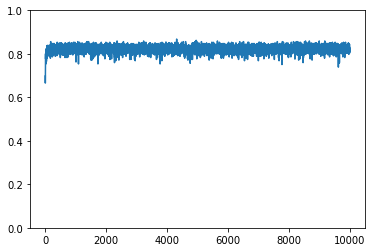

array([[ 0.34646186,  0.44748295,  0.94649706, ...,  1.        ,
         0.97      ,  0.99      ],
       [ 0.14192797,  0.18375892,  0.89440313, ...,  1.        ,
         0.96      ,  0.99      ],
       [ 0.11188559,  0.16763133,  0.84336595, ...,  1.        ,
         0.95      ,  0.99      ],
       ...,
       [-0.00847458,  0.18920282, -0.36896282, ...,  1.        ,
         0.89      ,  0.89      ],
       [-0.00366525,  0.18679133, -0.3690411 , ...,  1.        ,
         0.89      ,  0.89      ],
       [-0.00866525,  0.18439694, -0.36906067, ...,  1.        ,
         0.89      ,  0.89      ]])

In [57]:
perceptron = Perceptron()
perceptron.fit(X_train,Y_train,10000,0.01)